In [15]:
import imageio
import matplotlib.pyplot as plt
from argoverse.utils.se3 import SE3
import cv2
import numpy as np
import scipy.ndimage
import argoverse 
from argoverse.utils.se3 import SE3
from argoverse.data_loading.simple_track_dataloader import SimpleArgoverseTrackingDataLoader
from argoverse.utils.calibration import get_calibration_config

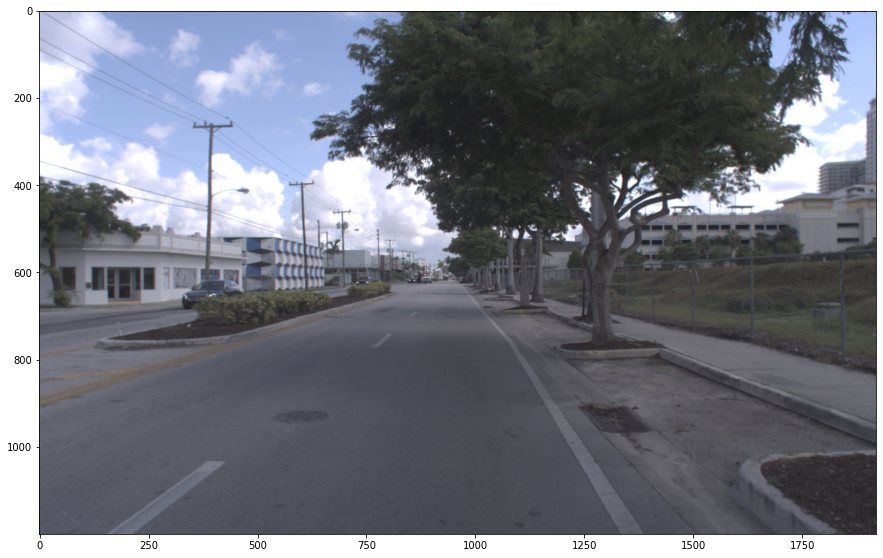

In [5]:
cam_timestamp = '315973061557317752'
log_id = 'c9d6ebeb-be15-3df8-b6f1-5575bea8e6b9'

ARGOVERSE_DATA_ROOT = './data/argo/argoverse-tracking/'
camera_name = 'ring_front_center'

split_data_dir = f'{ARGOVERSE_DATA_ROOT}/val'
img_fpath = f'{split_data_dir}/{log_id}/{camera_name}/{camera_name}_{cam_timestamp}.jpg'
img_front = imageio.imread(img_fpath)

fig = plt.figure(figsize=(15,10))
plt.imshow(img_front)
plt.show()

In [6]:
def homography_from_calibration(camera_SE3_ground: SE3, K: np.ndarray) -> np.ndarray:
    """
    See Hartley Zisserman, Section 8.1.1
    """
    r1 = camera_SE3_ground.transform_matrix[:3,0].reshape(-1,1)
    r2 = camera_SE3_ground.transform_matrix[:3,1].reshape(-1,1)
    t =  camera_SE3_ground.transform_matrix[:3,3].reshape(-1,1)
    
    img_H_ground = K.dot(np.hstack([r1,r2,t]))
    return img_H_ground

In [8]:
dl = SimpleArgoverseTrackingDataLoader(data_dir=split_data_dir, labels_dir=split_data_dir)
city = dl.get_city_name(log_id)
city_SE3_egovehicle = dl.get_city_to_egovehicle_se3(log_id, cam_timestamp)
calib_data = dl.get_log_calibration_data(log_id)
camera_config = get_calibration_config(calib_data, camera_name)

camera_SE3_egovehicle = camera_config.extrinsic
camera_R_egovehicle = camera_SE3_egovehicle[:3,:3]
camera_t_egovehicle = camera_SE3_egovehicle[:3,3]
camera_SE3_egovehicle = SE3(rotation=camera_R_egovehicle, translation=camera_t_egovehicle)
# Extract 3x3 intrinsics matrix
K = camera_config.intrinsic[:,:3]
AXLE_HEIGHT_FROM_GROUND = 0.33 # in meters, 
ground_SE3_egovehicle = SE3(rotation=np.eye(3), translation=np.array([0,0,AXLE_HEIGHT_FROM_GROUND]))
egovehicle_SE3_ground = ground_SE3_egovehicle.inverse()
camera_SE3_ground = camera_SE3_egovehicle.right_multiply_with_se3(egovehicle_SE3_ground)
img_H_ground = homography_from_calibration(camera_SE3_ground, K)
ground_H_img = np.linalg.inv(img_H_ground)

LATERAL_EXTENT = 20 # look 20 meters left and right
FORWARD_EXTENT = 40 # look 40 meters ahead

resolution = 0.01 # in meters/px
out_width = int(FORWARD_EXTENT / resolution)
out_height = int(LATERAL_EXTENT*2 / resolution)

RESCALING = int(1/resolution) # pixels/meter, if rescaling=1, then 1 px/1 meter
SHIFT = int(out_width//2)
shiftedground_H_ground = np.array(
    [
        [RESCALING,0,0],
        [0,RESCALING,SHIFT],
        [0,0,1]
    ])
shiftedground_H_img = shiftedground_H_ground.dot(ground_H_img)
# We use OpenCV to perform the interpolation needed during warping:
bev_img = cv2.warpPerspective(img_front, shiftedground_H_img, dsize=(out_width, out_height))

In [10]:
print('H Rank: ', np.linalg.matrix_rank(img_H_ground))
print('H Rank: ', np.linalg.matrix_rank(ground_H_img))
print('H Rank: ', np.linalg.matrix_rank(shiftedground_H_ground))

H Rank:  3
H Rank:  3
H Rank:  3


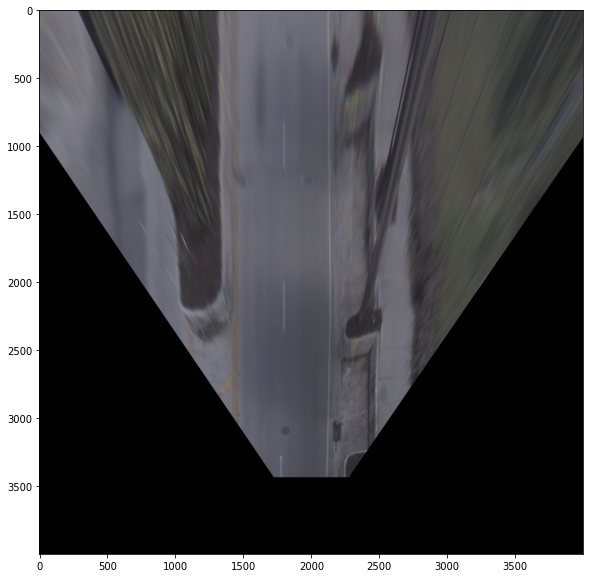

In [13]:
# fig = plt.figure(figsize=(15,10))
# plt.imshow(img_front)
# plt.show()

fig = plt.figure(figsize=(15,10))
bev_img = np.flipud(bev_img)
bev_img = scipy.ndimage.rotate(bev_img, angle=90)
plt.imshow(bev_img)
plt.show()

In [14]:
bev_img.shape


(4000, 4000, 3)